In [2]:
# Put your code here

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

# import data
df = pd.read_csv('./dataset.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.drop(columns=['id','keyword','location'])

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


## 1. Data Preprocessing + EDA

In [5]:
# remove irrelavant features and check for null and duplicate
col = ['text','target']
df = df[col]
print(df.isnull().sum())
print(df['text'].duplicated().any())

text      0
target    0
dtype: int64
True


In [6]:
# text cleaning

from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def pre_process(text):
    #remove url
    text = re.sub(r'http\S+', '', text)
    #remove special characters
    text = re.sub('\W', ' ', text)
    #remove digits
    text = re.sub(r'\d+', '', text)
    #remove underline
    text = re.sub(r'_',' ', text)
    #remove numbering abcde
    text = re.sub(r' i+ ',' ',text)
    #remove numbering i ii iii
    text = re.sub(r' [abcde] ',' ',text)    
    #remove white spaces
    text = re.sub(r'\s+',' ', text)
    #to lower
    text = text.lower()
    #remove stopwords
    text =' '.join([word for word in text.split() if word not in (stop_words)])
    #lemmatize
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    
    return text
df['text_original'] = df['text'] # keep original provision
df['text'] = df['text'].apply(lambda text: pre_process(text))
df = df[['text','text_original','target']]
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yangy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yangy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yangy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\yangy\AppData\Local\Temp/ipykernel_13748/1557609529.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_original'] = df['text'] # keep original provision
C:\Users\yangy\AppData\Local\Temp/ipykernel_13748/1557609529.py:35: SettingWithCopyWarning: 
A value is trying 

,text,text_original,target
0,deed reason earthquake may allah forgive u,Our Deeds are the Reason of this #earthquake M...,1
1,forest fire near la ronge sask canada,Forest fire near La Ronge Sask. Canada,1
2,resident asked shelter place notified officer ...,All residents asked to 'shelter in place' are ...,1
3,people receive wildfire evacuation order calif...,"13,000 people receive #wildfires evacuation or...",1
4,got sent photo ruby alaska smoke wildfire pour...,Just got sent this photo from Ruby #Alaska as ...,1


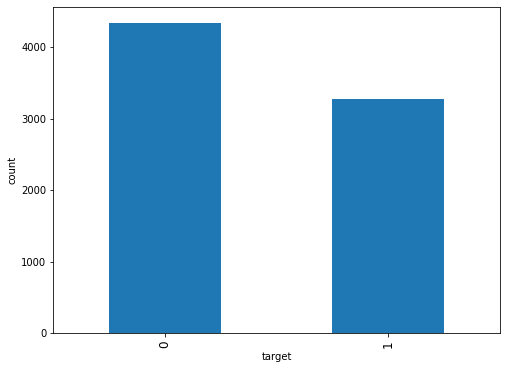

In [8]:
# EDA
# visualizing class distribution
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('target').text.count().plot.bar(ylim=0)
plt.xticks(fontsize=12)
plt.ylabel('count')
plt.show()
# class imbalance observed, might employ some oversampling technique

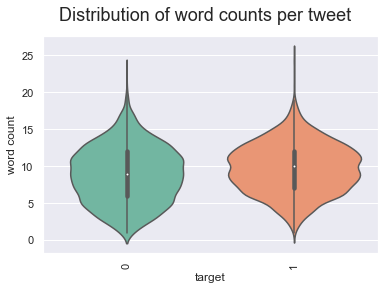

In [15]:
# visualize word counts in each provision by label

import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,4))
sns.violinplot(x = 'target', y = df['text'].str.split().str.len(), data = df, palette = 'Set2')
plt.suptitle('Distribution of word counts per tweet',fontsize=18)
plt.ylabel('word count')
plt.xticks(rotation=90)
plt.show()

In [17]:
import spacy
!python -m spacy download en_core_web_sm
nlp= spacy.load('en_core_web_sm')

     --------------------------------------- 13.9/13.9 MB 10.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


You should consider upgrading via the 'C:\Users\yangy\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [18]:
# POS Tagging
def get_pos(data):
    N = len(data)
    verbs_count = []
    adjs_count = []
    nouns_count = []
    propns_count = []
    for i in range(N):
        string = nlp(data.values[i])
        #count verbs
        verbs = [token.text for token in string if token.pos_ == 'VERB']
        verbs_count.append(len(verbs))
        #count adjs
        adjs = [token.text for token in string if token.pos_ == 'ADJ']
        adjs_count.append(len(adjs))
        #count nouns
        nouns = [token.text for token in string if token.pos_ == 'NOUN']
        nouns_count.append(len(nouns))
        #count propns
        propns = [token.text for token in string if token.pos_ == 'PROPN']
        propns_count.append(len(propns))
            
    return verbs_count, adjs_count, nouns_count, propns_count

In [19]:
df_new = df.copy()
df_new['verbs_count'], df_new['adjs_count'], df_new['nouns_count'], df_new['propns_count']= get_pos(df_new['text'])

In [20]:
df_new

,text,text_original,target,verbs_count,adjs_count,nouns_count,propns_count
0,deed reason earthquake may allah forgive u,Our Deeds are the Reason of this #earthquake M...,1,2,0,3,1
1,forest fire near la ronge sask canada,Forest fire near La Ronge Sask. Canada,1,0,0,2,3
2,resident asked shelter place notified officer ...,All residents asked to 'shelter in place' are ...,1,3,0,8,0
3,people receive wildfire evacuation order calif...,"13,000 people receive #wildfires evacuation or...",1,1,0,4,1
4,got sent photo ruby alaska smoke wildfire pour...,Just got sent this photo from Ruby #Alaska as ...,1,2,0,3,3
...,...,...,...,...,...,...,...
7608,two giant crane holding bridge collapse nearby...,Two giant cranes holding a bridge collapse int...,1,1,2,4,0
7609,aria ahrary thetawniest control wild fire cali...,@aria_ahrary @TheTawniest The out of control w...,1,0,5,4,2
7610,utc km volcano hawaii,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,0,0,1,3
7611,police investigating bike collided car little ...,Police investigating after an e-bike collided ...,1,4,4,8,0


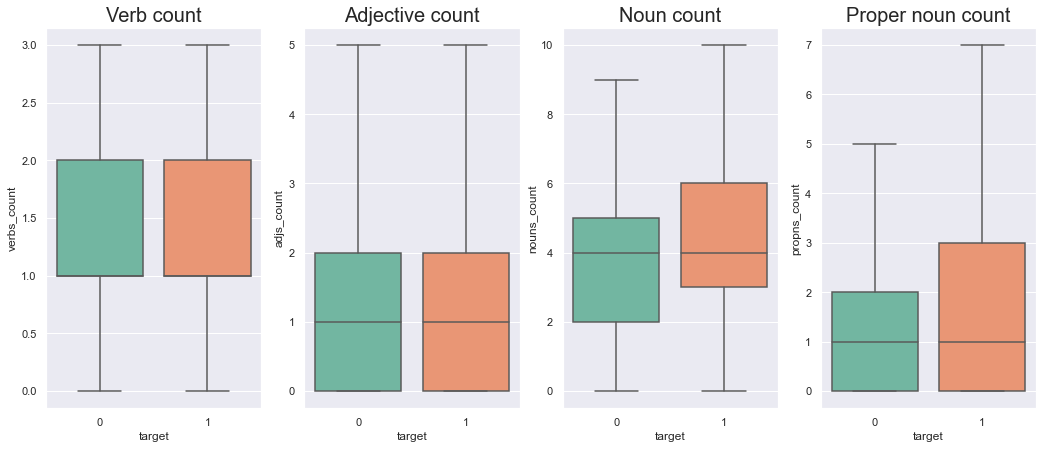

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,7))
# fig.suptitle('Comparison of quantity attributes', fontsize = 20)

sns.boxplot(x = df_new['target'], y = df_new['verbs_count'], data = df_new, palette = 'Set2', showfliers = False, ax=ax1)
ax1.set_title('Verb count', fontsize = 20)

sns.boxplot(x = df_new['target'], y = df_new['adjs_count'], data = df_new, palette = 'Set2', showfliers = False, ax=ax2)
ax2.set_title('Adjective count', fontsize = 20)

sns.boxplot(x = df_new['target'], y = df_new['nouns_count'], data = df_new, palette = 'Set2', showfliers = False, ax=ax3)
ax3.set_title('Noun count',fontsize = 20)

sns.boxplot(x = df_new['target'], y = df_new['propns_count'], data = df_new, palette = 'Set2', showfliers = False, ax=ax4)
ax4.set_title('Proper noun count', fontsize = 20)

plt.subplots_adjust(right=1.5)

plt.show()